<a href="https://colab.research.google.com/github/carolina-garay/M_Espacios_Verdes_2022_Grupo1/blob/Seba-Ormaechea/P1_EspVerdes_Grupo1_SGO_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Espacios Verdes. Práctico de análisis y visualización
Grupo 1: 
- Artola, María Fernanda
- Garay, Carolina
- Nievas, Rafael
- Ormaechea, Sebastián

## Introducción
El monitoreo de espacios verdes mediante sensores remotos (satélites), puede ser una alternativa interesante para aquellos municipios que busquen preservar el buen estado de estos sitios, reduciendo la necesidad de personal especializado para el control in situ. Sería interesante que este monitoreo implique la sistematización de tareas de control y brinde indicadores efectivos para advertir estados de deterioro que requieran ser atendidos. Se espera que el análisis de datos provistos con imágenes satelitales e indicadores como NVDI (Indice Diferencial de Vegetación Normalizado), permita detectar cambios en la condición de la vegetación a través de las estaciones del año y eventualmente detectar cambios anormales que representen estados preliminares de degradación de estos espacios. 
Por otro lado, es posible que la resolución de las imagenes no permita detectar cambios a nivel de arboles individuales o que, en casos de vegetación multiestratificada, no se puedan advertir los cambios en cado estrato. 

## Presentación del Dataset
El dataset disponible se encuentra en formato tabular y cuenta con 208932 registros (filas) que representan diferentes espacios verdes (plazas. parques, etc.) de la ciudad de Córdoba, tomados en diferentes fechas desde el año 2017 al 2022. La obtención de diferentes fechas para una misma zona es lo que permite luego un análisis de evolución temporal de la vegetación. 

El dataset también cuenta con 167 columnas que caracterizan cada uno de los  registros mediante los siguientes estadísticos o propiedades: 
- {B0i/indice}_{min,max,mean,median,nodata,range,count}:
 - min: valor mínimo alcanzado por la Banda o indice en la zona de interés.
 - max: valor máximo alcanzado por la Banda o indice en la zona de interés.
 - median: mediana alcanzada por la Banda o indice en la zona de interés.
 - nodata: cantidad de valores nulos en la Banda o indice en la zona de interés.
 - range: rango de los valores alcanzado por la Banda o indice en la zona de interés.
 - count: cantidad de valores en la zona de interés (count + nodata son la cantidad total de pixeles de un dado espacio verde)
- raster: raster del cual se extraen los estadísticos
- clouds_on_raster: nubosidad del raster completo
- osm_id: identificador asociado a la capa original (atlas-espacios-verdes)
- name: nombre del espacio ( si es que lo tiene, por ejemplo, Parque Sarmiento).
- area_m2: area en metros cuadrados
- date: fecha de la muestra. 

Los estadísticos fueron calculados en base a rasters. En forma simplificada un raster es una grilla de puntos, cada uno de los cuales tiene alguna clase de identificación geográfica, que permite ubicarlos en el espacio. Además, cada una de esas grillas de puntos se corresponde a una "banda". Se hace referencia a banda porque esta asociada a un rango (espectral) en el cual el elemento sensor es capaz de "ver" o "capturar" datos. Cada punto de la grilla tiene un valor que se corresponde con lo medido por el instrumento específico en el satélite. También es importante considerar, que un raster no tiene necesariamente 1 sola banda sino que puede tener mas. Particularmente en este caso, los rasters provistos comprenden 10 Bandas.

Los rasters fueron obtenidos a partir de imágenes satelitales del [Proyecto Copernicus](https://www.copernicus.eu/es/sobre-copernicus/infraestructura) y uno de sus satélites Sentinel (Sentinel 2), con una resolución de entre 2 a 10 metros. Para la descarga de estas imágenes primero se definió la zona general de interés y también ciertas características o features específicas para abordar el problema de interés. En el caso del presente dataset, la zona de interés es la Ciudad de Córdoba, la cual es enteramente captada por una pisada del satelite denominada Tile 20JLL. 
 

A modo de ejemplo de los resultados del dataset, se muestra a continuación una imagen jpg del Indice Diferencial de Vegetación Normalizado (con un threshold arbitrario de 0.45) para la ciudad de Córdoba.

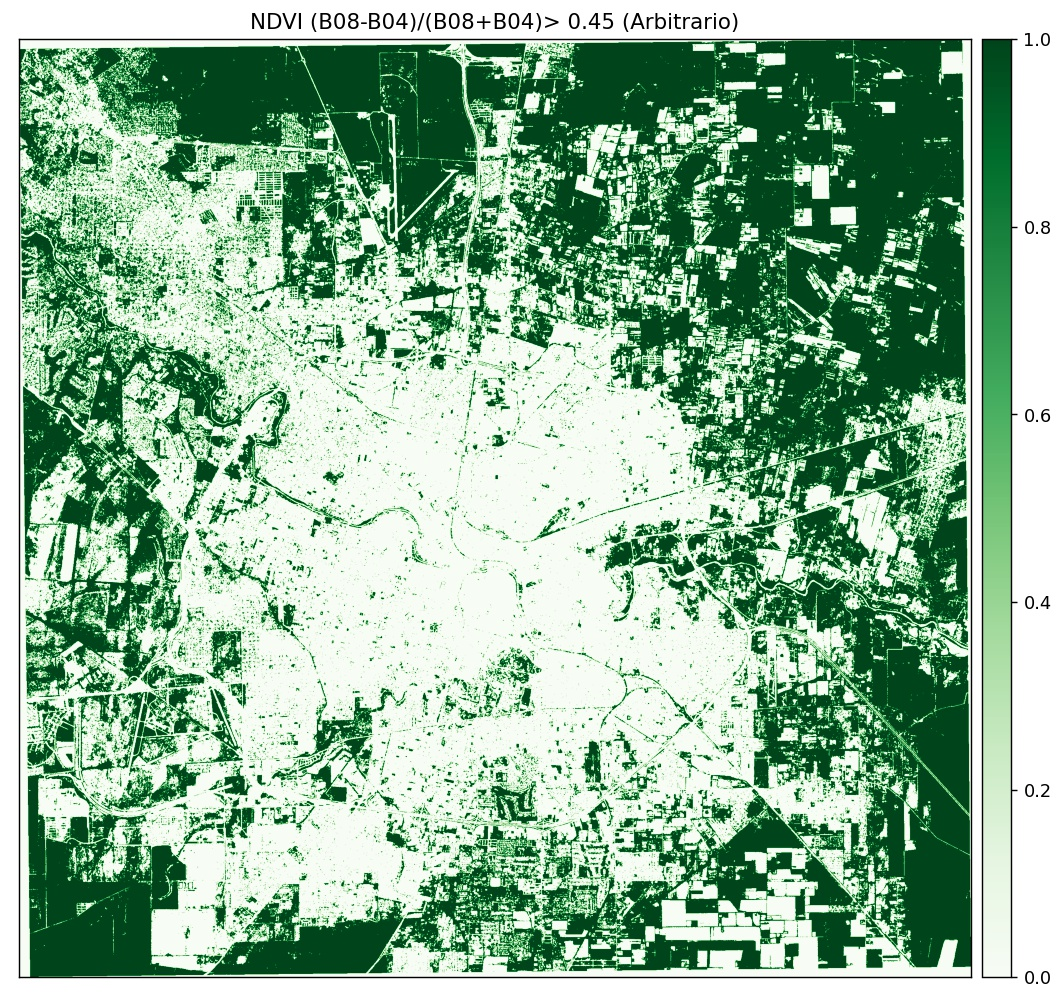

In [ ]:
# Setup necesario para correr pandas profiling
!pip install pandas_profiling==2.8.0
!pip install pandas==1.2.0

In [32]:
# Importación necesaria para correr pandas profiling y descargar reporte
from pandas_profiling import ProfileReport
from google.colab import files

In [33]:
# Descarga de base de datos
# from link @ https://github.com/felixlapalma/monitoreo-espacios-verdes-diplo202X/blob/main/data/ab-initio-dataset-build.md
!gdown https://drive.google.com/file/d/1tgbIQaEXzIghcFYyd2YM9iMho4TDHHFd/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1tgbIQaEXzIghcFYyd2YM9iMho4TDHHFd
To: /content/espacios-verdes-indexs-cba-20170101-20220420.zip
100% 170M/170M [00:01<00:00, 142MB/s]


In [34]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates # Esto sirve para manipular fechas en los gráficos
import datetime

In [35]:
# Lectura de csv y obtención de dataframe 
df_=pd.read_csv('/content/espacios-verdes-indexs-cba-20170101-20220420.zip',index_col=0)

In [36]:
# Exploración del dataset. Usamos "display" en lugar de "print" porque ofrece una mejor visualización de la tabla
display(df_.head())

,B02_min,B02_max,B02_mean,B02_median,B02_nodata,B02_range,B02_count,B03_min,B03_max,B03_mean,...,sipi_median,sipi_nodata,sipi_range,sipi_count,raster,clouds_on_raster,osm_id,name,area_m2,date
0,0.0871,0.1421,0.102570,0.09650,0.0,0.0550,47,0.0768,0.1516,0.098885,...,0.884216,0.0,0.453065,47,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,605976736,NaN,4650.710032,2017-01-03
1,0.0970,0.1936,0.118354,0.10660,0.0,0.0966,13,0.1006,0.1949,0.122154,...,0.971875,0.0,0.247045,13,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559322368,NaN,1502.000513,2017-01-03
2,0.0992,0.1273,0.111805,0.11290,0.0,0.0281,19,0.1037,0.1369,0.117795,...,0.973017,0.0,0.207006,19,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559322369,NaN,2004.192528,2017-01-03
3,0.0995,0.1933,0.118491,0.11355,0.0,0.0938,66,0.0993,0.1990,0.124512,...,0.966202,0.0,0.258424,66,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328111,NaN,6940.507640,2017-01-03
4,0.1059,0.1385,0.122453,0.12240,0.0,0.0326,47,0.1036,0.1580,0.132455,...,0.993986,0.0,0.260419,47,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328112,NaN,4587.356048,2017-01-03


In [37]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208932 entries, 0 to 208931
Columns: 167 entries, B02_min to date
dtypes: float64(140), int64(24), object(3)
memory usage: 267.8+ MB


In [38]:
# Imprimimos todas las variables para verificar sus nombres
print(df_.columns.tolist())

['B02_min', 'B02_max', 'B02_mean', 'B02_median', 'B02_nodata', 'B02_range', 'B02_count', 'B03_min', 'B03_max', 'B03_mean', 'B03_median', 'B03_nodata', 'B03_range', 'B03_count', 'B04_min', 'B04_max', 'B04_mean', 'B04_median', 'B04_nodata', 'B04_range', 'B04_count', 'B05_min', 'B05_max', 'B05_mean', 'B05_median', 'B05_nodata', 'B05_range', 'B05_count', 'B06_min', 'B06_max', 'B06_mean', 'B06_median', 'B06_nodata', 'B06_range', 'B06_count', 'B07_min', 'B07_max', 'B07_mean', 'B07_median', 'B07_nodata', 'B07_range', 'B07_count', 'B8A_min', 'B8A_max', 'B8A_mean', 'B8A_median', 'B8A_nodata', 'B8A_range', 'B8A_count', 'B08_min', 'B08_max', 'B08_mean', 'B08_median', 'B08_nodata', 'B08_range', 'B08_count', 'B11_min', 'B11_max', 'B11_mean', 'B11_median', 'B11_nodata', 'B11_range', 'B11_count', 'B12_min', 'B12_max', 'B12_mean', 'B12_median', 'B12_nodata', 'B12_range', 'B12_count', 'ndvi_min', 'ndvi_max', 'ndvi_mean', 'ndvi_median', 'ndvi_nodata', 'ndvi_range', 'ndvi_count', 'ndwi_min', 'ndwi_max', 

## Análisis Estadístico de Variables

Para este práctico, seleccionamos las siguientes variables para analizar: 

- osm_id: Este es un identificador asociado a la capa original (atlas-espacios-verdes).
- date: Fecha de la muestra.
- B02_median: Mediana alcanzada por la Banda 02. 
- ndvi_max: Valor máximo alcanzado por el indice NDVI.
- area_m2: Área en metros cuadrados

**Variables**: ¿Qué _tipo de variable_ es cada una? Parecen estar acotadas? ¿Son fisicamente razonables?

In [39]:
df_[["B02_median", "osm_id", "date", "ndvi_max", "area_m2"]].dtypes

B02_median    float64
osm_id          int64
date           object
ndvi_max      float64
area_m2       float64
dtype: object

- osm_id: Variable numérica discreta con tipo de dato int64.
- date: Variable de fecha con tipo de dato object, acotadas a un período de tiempo entre el año 2017 a 2022.
- B02_median: Variable numérica continua con tipo de dato float64.   
- ndvi_max: Variable numérica continua con tipo de dato float64.
- area_m2: Variable numérica continua con tipo de dato float64.

**Outliers**: ¿Existen _outliers_ en las variables seleccionadas? (Note que en la presentación de los datos, esto parece estar presente en casi todos los casos) 

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
BANDS = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B08", "B11", "B12"]
TEST_COLS=[f"{B}_median" for B in BANDS]
df_bandas=df_.loc[:,TEST_COLS]

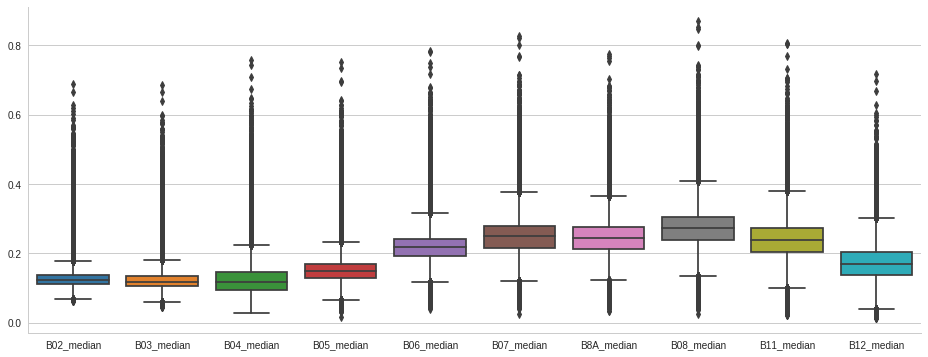

In [42]:
# Se contemplan todas las bandas a fines comparativos con la banda 02
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=df_bandas)                  
sns.despine()

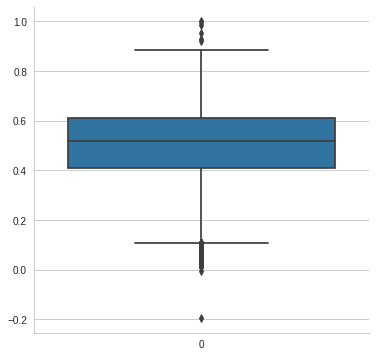

In [43]:
plt.figure(figsize=(6, 6))
g = sns.boxplot(data=df_["ndvi_max"])                  
sns.despine()

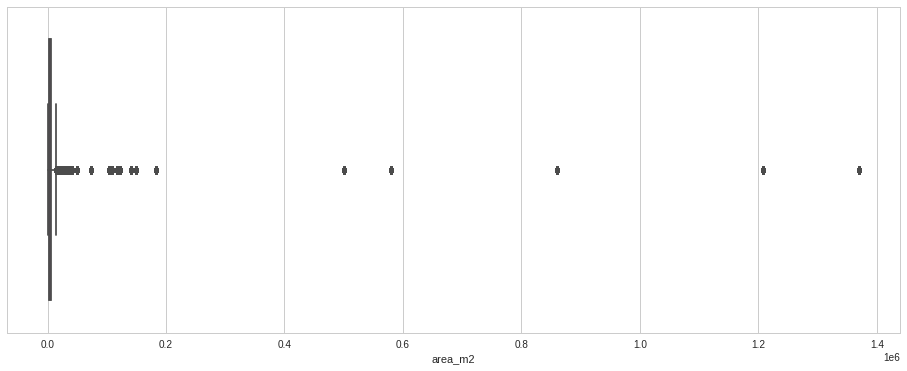

In [44]:
plt.figure(figsize=(16, 6))
sns.boxplot(x=df_["area_m2"], color='magenta');

In [45]:
# La distribución de la variable "area_m2" es difícil de apreciar mediante gráficos dada la presencia de pocos valores muy grandes (outliers).
# Por ello, estimamos medidas de tendencia central para conocer mejor esta importante variable.
df_["area_m2"].describe().apply(lambda s: '{0:.2f}'.format(s))

count     208932.00
mean       12493.88
std        78957.30
min          422.60
25%         2066.56
50%         3812.18
75%         6644.79
max      1370630.49
Name: area_m2, dtype: object

- osm_id: Esta es una variable identificadora por lo que no tiene interés analizar outliers. 
- date: Esta variable tiene valores en formato de fecha por lo que no se puede analizar la presencia de outliers.
- B02_median: Se observan una importante cantidad de outliers, lo cual es común al resto de las bandas.   
- ndvi_max: Se observan outliers tanto en la parte superior como inferior de la distribución de valores.
- area_m2: Se observan valores muy grandes que contrastan con la mayoría de los observados. A pesar de ser valores atípicos, son valores razonables dada la heterogeneidad en el tamaño de los espacios verdes de una ciudad.

**Valores Faltantes**: ¿Existen? ¿Es mejor descartarlos o completarlos con un valor particular? (Quizas le sirva responder la siguiente pregunta en primer lugar)

In [46]:
# Para detectar valores faltantes primero analizamos un reporte de pandas profiling:
# Análisis estadístico de bandas mediante pandas profiling
profileBandas = ProfileReport(df_bandas)
profileBandas.to_file('df_BandasReport.html')
files.download('df_BandasReport.html')

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Análisis de las variables seleccionadas mediante pandas profiling
df_Vars=df_.loc[:,["B02_median", "osm_id", "date", "ndvi_max", "area_m2"]]
profileVars = ProfileReport(df_Vars)
profileVars.to_file('df_VarsReport.html')
files.download('df_VarsReport.html')

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- osm_id: No tiene valores faltantes.
- date: No tiene valores faltantes.
- B02_median: Tiene casi un 20% de valores faltantes. Sin embargo, es algo propio de todas las bandas presentes en el dataset   
- ndvi_max: Tiene casi un 20% de valores faltantes.
- area_m2: No tiene valores faltantes.

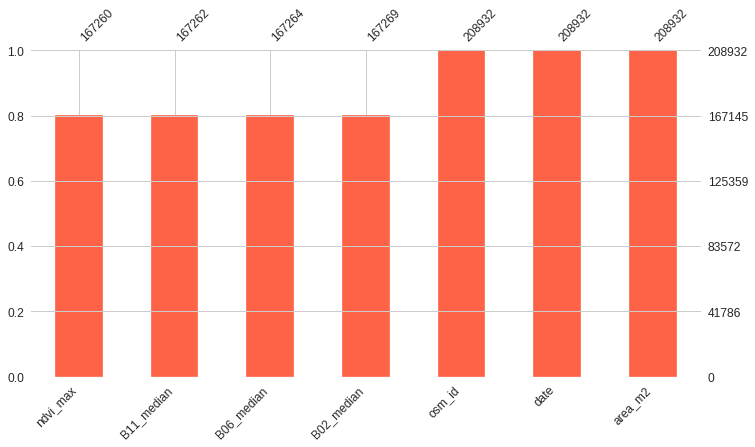

In [48]:
# Utilizamos la librería missingno para el análisis de datos faltantes 
import missingno as msno
# Graficamos los datos faltantes de varias variables, incluidas las de interés
df_interest = df_[["B02_median", "B06_median", "B11_median","osm_id", "date", "ndvi_max", "area_m2"]]
msno.bar(df_interest,figsize=(12, 6), sort="ascending",fontsize=12, color='tomato') 

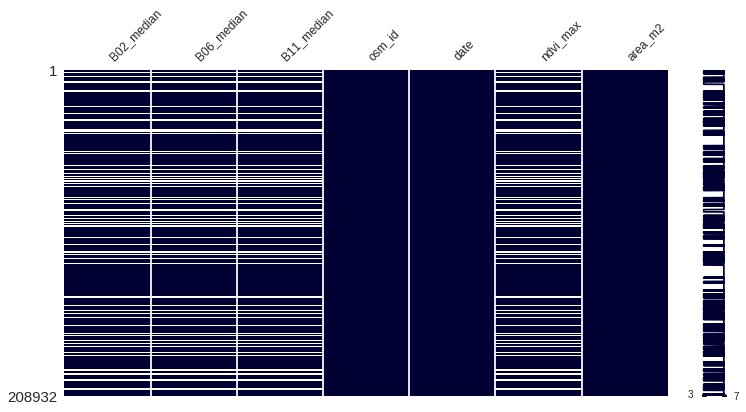

In [49]:
# Para analizar si hay una correlación entre los datos faltantes, graficamos una matrix 
msno.matrix(df_interest,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

La primera gráfica mostró que existen el mismo porcentaje de valores faltantes para todas las bandas y el indicador analizado. La siguiente gráfica muestra claramente que hay correlación entre los valores faltantes por lo que la pérdida de datos obedece a un mismo causante. En el caso del indicador NDVI es lógico que se observe correlación con las bandas ya que este se construye en base a valores específicos de las bandas. En el caso de las bandas entre si, es posible que su correlación tenga que ver con que el instrumento del satélite falló en determinados momentos o que la alta presencia de nubes impidió obtener valores de todas las bandas. Por ende, es posible que sea debido a un error no aleatorio correspondiente a características no observadas.
En respuesta a si es mejor descartar los registros con datos faltantes o imputarles un valor particular, entendemos que el descarte es necesario sino hay una forma razonable de estimar el dato faltante. La imputación podría realizarse mediante las técnicas específicas para series temporales, tales como Forward fill, Back fill e Interpolación lineal.

**Distribucion de Valores**: ¿Cómo es la _distribución_ de las variables en el dataset? ¿Se parecen a alguna distribucion que recuerde? Son todas de la misma distribución?

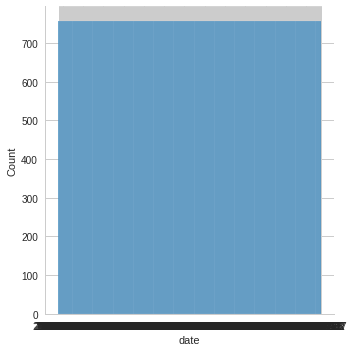

In [50]:
# Gráfica de la distribución de la variable date
sns.displot(df_['date'])

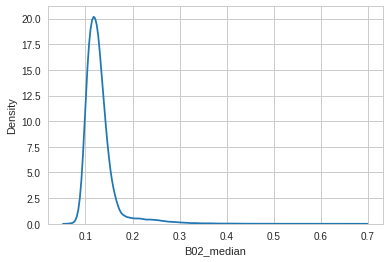

In [51]:
# Gráfica de la distribución de la variable B02_median
sns.kdeplot(df_['B02_median'])

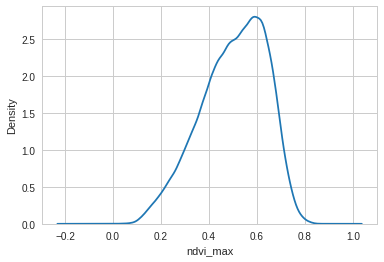

In [52]:
# Gráfica de la distribución de la variable ndvi_max
sns.kdeplot(df_['ndvi_max'])

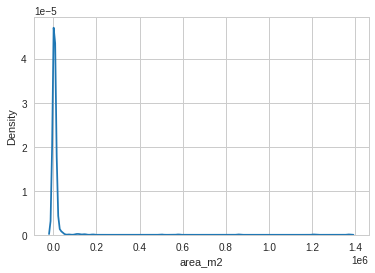

In [53]:
sns.kdeplot(df_['area_m2'])

- osm_id: Esta es una variable identificadora por lo que su distribución no tiene interés.
- date: Se cuenta con la misma cantidad de casos para todos los valores (fechas) por lo que es una distribución equiprobable.
- B02_median: La distribución parece ser de tipo normal con valores extremos a la derecha.  
- ndvi_max: La distribución parece ser de tipo normal.
- area_m2: Aunque la mayoría de los valores conforman una distribución normal típica, hay un sego de distribución hacia la derechadado por la presencia de outliers.

**Distribucion Condicionada**: ¿Cómo es la distribución de una variable (cualquiera que haya elegido) condicionada a la variable temporal por ejemplo? ¿Tiene sentido utilizar la dependencia temporal cuando estamos intentando completar valores faltantes?

In [54]:
# Convertimos la columna de fecha de tipo object a datetime
from datetime import date
from datetime import datetime
df_['date'] = pd.to_datetime(df_['date'])
df_[["B02_median", "osm_id", "date", "ndvi_max", "area_m2"]].dtypes

B02_median           float64
osm_id                 int64
date          datetime64[ns]
ndvi_max             float64
area_m2              float64
dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



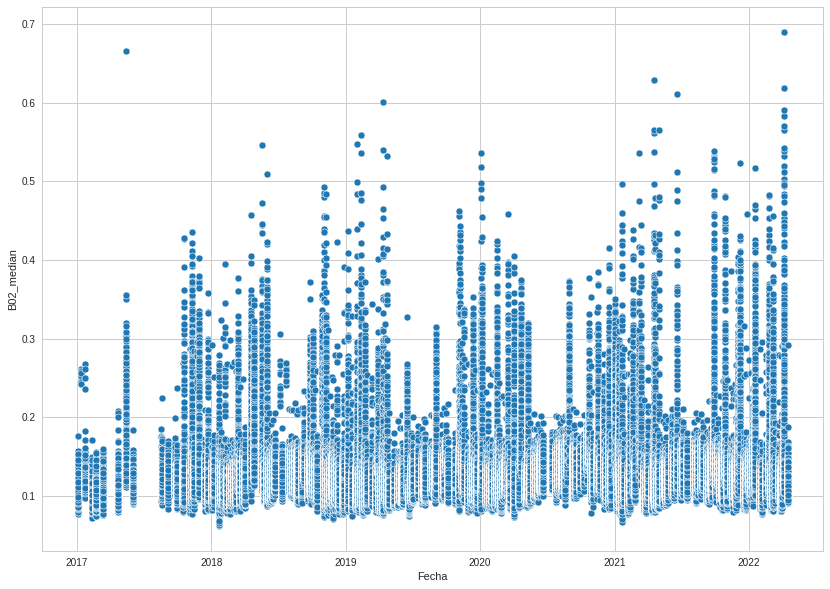

In [55]:
# Graficamos las variables seleccionadas en función del tiempo
plt.figure(figsize=(14, 10))
sns.scatterplot(df_['date'], df_['B02_median'])
plt.xlabel("Fecha")
plt.ylabel("B02_median");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'ndvi_max')

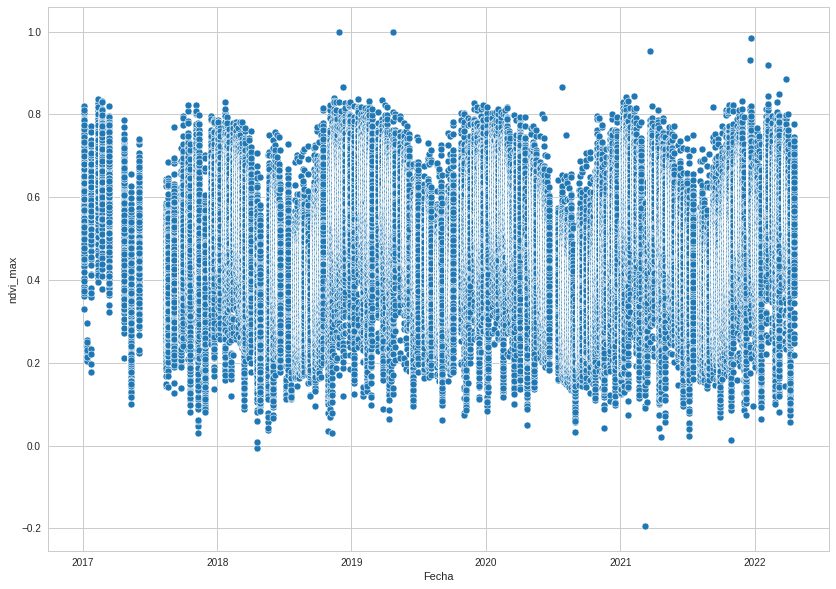

In [56]:
plt.figure(figsize=(14, 10))
sns.scatterplot(df_['date'], df_['ndvi_max'])
plt.xlabel("Fecha")
plt.ylabel("ndvi_max")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Área (m2)')

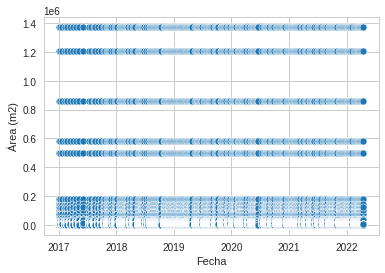

In [57]:
sns.scatterplot(df_['date'], df_['area_m2'])
plt.xlabel("Fecha")
plt.ylabel("Área (m2)")

La distribución de las variables B02_median y ndvi_max en función del tiempo, muestran una fuerte alternancia intranual, con un patrón que parece repetirse entre años. Sin embargo, la excesiva cantidad de puntos hace necesario la realización de gráficas más específicas. Por otra parte, este tipo de gráficos, también resalta valores raros (ndvi_max = -0,2) que deberían ser eliminados.
La última gráfica sobre la variable "area_m2" no muestra variación lo cual era esperable, salvo que hubiera sucedido el caso que aumentara o disminuyera la superficie de un espacio verde . 
En respuesta a la posibilidad de utilizar la dependencia temporal para la imputación de valores faltantes, parece ser una opción razonable dada la recurrencia anual en la alternancia de valores. 

En caso de calcular estadísticos, explicar por qué lo hicieron y que buscaban obtener al calcularlos. Utilizar los gráficos apropiados para mostrar el análisis realizado.  
Además:


-  ¿Existe _correlacion_ entre variables? ¿Entre cuales es mas "intensa"? -> Considere utilizar  [__pandas-profiling__](https://github.com/ydataai/pandas-profiling)

El análisis mediante pandas profiling, permite detectar una alta correlación entre las medianas de las bandas 02, 03, 04 y 05 por un lado. También hay alta correlación entre las medianas de las bandas 06, 07, 08 y 8A. Finalmente, también muestran alta correlación las medianas de las bandas 11 y 12. Se destaca particularmente la "intensa" correlación entre las bandas 07 y 08.

-  Analizar la dispersión de las bandas (para un estadistico, por ejemplo la media) a lo largo del tiempo. ¿La dispersión es la misma en todos los casos? ¿O existen bandas que "se dispersan" mas?

Utilizar gráficos que permitan visualizar de un modo simple las conclusiones.

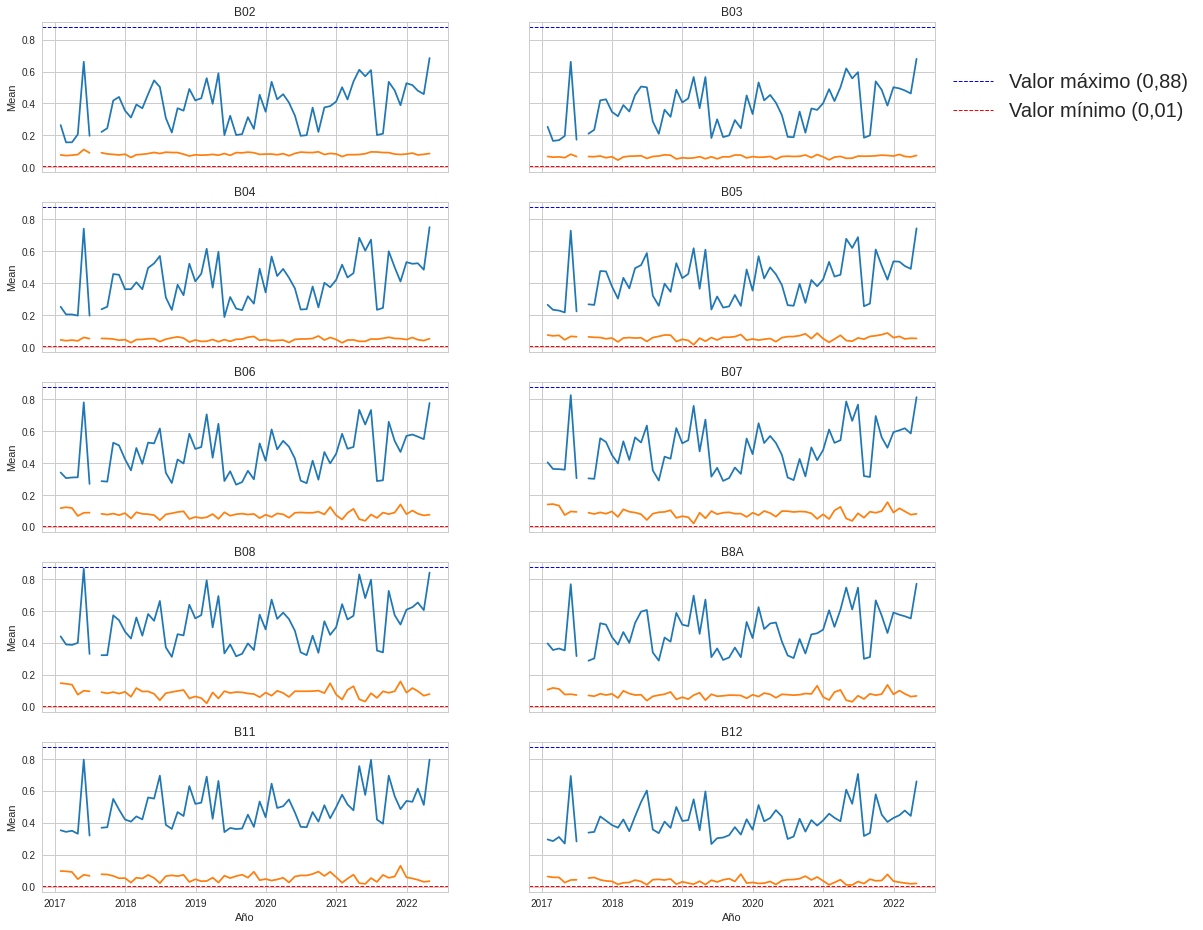

In [58]:
# Graficamos la dispersión de cada una de las bandas a lo largo del tiempo agrupando por mes (freq='M'). 
# Para facilitar la comparación se grafican todas las bandas en un mismo plot y se mantienen las escalas de ambos ejes
# Para facilitar la observación de la dispersión de valores, se grafican líneas segmentadas para el valor máximo y mínimo observado  
MeanB02= df_.groupby(pd.Grouper(key='date',freq='M')).B02_mean.agg([max, min])
MeanB03= df_.groupby(pd.Grouper(key='date',freq='M')).B03_mean.agg([max, min])
MeanB04= df_.groupby(pd.Grouper(key='date',freq='M')).B04_mean.agg([max, min])
MeanB05= df_.groupby(pd.Grouper(key='date',freq='M')).B05_mean.agg([max, min])
MeanB06= df_.groupby(pd.Grouper(key='date',freq='M')).B06_mean.agg([max, min])
MeanB07= df_.groupby(pd.Grouper(key='date',freq='M')).B07_mean.agg([max, min])
MeanB08= df_.groupby(pd.Grouper(key='date',freq='M')).B08_mean.agg([max, min])
MeanB8A= df_.groupby(pd.Grouper(key='date',freq='M')).B8A_mean.agg([max, min])
MeanB11= df_.groupby(pd.Grouper(key='date',freq='M')).B11_mean.agg([max, min])
MeanB12= df_.groupby(pd.Grouper(key='date',freq='M')).B12_mean.agg([max, min])
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16, 16), sharex=True, sharey=True)
ax[0, 0].plot(MeanB02)
ax[0, 1].plot(MeanB03)
ax[1, 0].plot(MeanB04)
ax[1, 1].plot(MeanB05)
ax[2, 0].plot(MeanB06)
ax[2, 1].plot(MeanB07)
ax[3, 0].plot(MeanB08)
ax[3, 1].plot(MeanB8A)
ax[4, 0].plot(MeanB11)
ax[4, 1].plot(MeanB12)
ax[0, 0].set_title("B02")
ax[0, 1].set_title("B03")
ax[1, 0].set_title("B04")
ax[1, 1].set_title("B05")
ax[2, 0].set_title("B06")
ax[2, 1].set_title("B07")
ax[3, 0].set_title("B08")
ax[3, 1].set_title("B8A")
ax[4, 0].set_title("B11")
ax[4, 1].set_title("B12")
ax[4, 0].set_xlabel("Año")
ax[4, 1].set_xlabel("Año")
ax[0, 0].set_ylabel("Mean")
ax[1, 0].set_ylabel("Mean")
ax[2, 0].set_ylabel("Mean")
ax[3, 0].set_ylabel("Mean")
ax[4, 0].set_ylabel("Mean")
ax[0, 0].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[0, 0].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[0, 1].axhline(y=0.88, color='blue', linestyle='--', linewidth=1, label="Valor máximo (0,88)")
ax[0, 1].axhline(y=0.01, color='red', linestyle='--', linewidth=1, label="Valor mínimo (0,01)")
ax[1, 0].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[1, 0].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[1, 1].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[1, 1].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[2, 0].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[2, 0].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[2, 1].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[2, 1].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[3, 0].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[3, 0].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[3, 1].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[3, 1].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[4, 0].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[4, 0].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[4, 1].axhline(y=0.88, color='blue', linestyle='--', linewidth=1)
ax[4, 1].axhline(y=0.01, color='red', linestyle='--', linewidth=1)
ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

La dispersión de valores de media a lo largo del tiempo, muestra valores mínimos bastante similares entre las bandas. Por otra parte, las bandas 08 y 07 alcanzan valores de media evidentemente mas elevados que el resto de las bandas. Por ende, estas son las que alcanzan mayor dispersión de valores.

##Series temporales
Como las observaciones se encuentran indexadas en el tiempo, este tipo de datos se conocen como **series de tiempo**. Elija alguno de los espacios verdes mas conocidos (Parque Sarmiento por ejemplo) y responda: 

- ¿Cual es el período de tiempo bajo análisis?

In [59]:
print(df_[df_['name'] == 'Parque Sarmiento']['date'].min())
print(df_[df_['name'] == 'Parque Sarmiento']['date'].max())
Inicio = df_[df_['name'] == 'Parque Sarmiento']['date'].min()
Final = df_[df_['name'] == 'Parque Sarmiento']['date'].max()
print('El período de tiempo bajo análisis es de', str(Final - Inicio))

2017-01-03 00:00:00
2022-04-17 00:00:00
El período de tiempo bajo análisis es de 1930 days 00:00:00


- Elija una banda y un indice (B02 y NDVI, por ejemplo) ambos parecen seguir alguna estacionalidad? Es decir, sus valores parecen "repetirse" cada cierto periodo? (Para este analisis considere utilizar la mediana de todas las mediciones {}_median).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



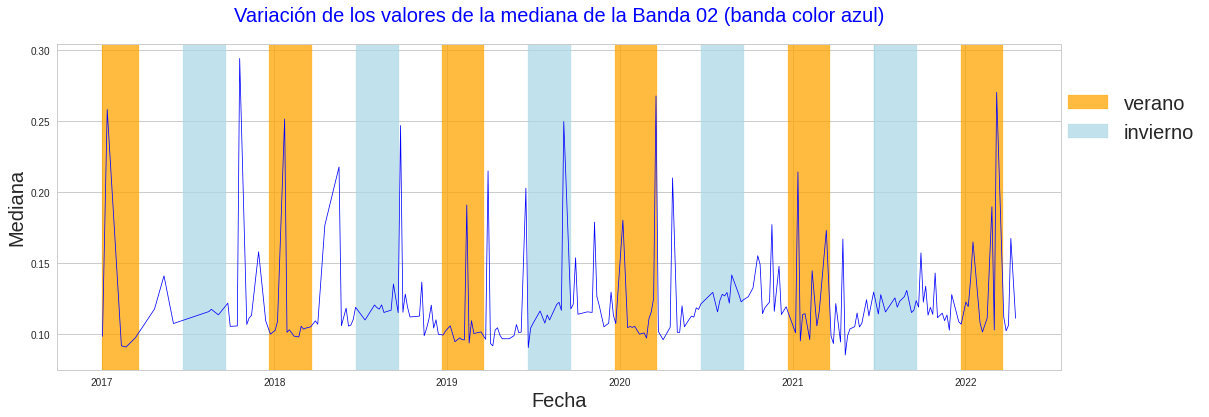

In [60]:
import matplotlib.dates as mdates # Esto sirve para manipular fechas en los gráficos
import datetime
Sarmiento = df_[df_['name'] == 'Parque Sarmiento']
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(Sarmiento['date'], Sarmiento['B02_median'], color="blue", linewidth=0.75)
yearlist = ['2017','2018','2019','2020','2021','2022']
for i in range(len(yearlist)):
  if yearlist[i] == '2017':
    ax.axvspan(mdates.date2num(datetime.datetime(2017,1,3)), mdates.date2num(datetime.datetime(2017,3,21)),
               color="orange",label="verano", alpha=0.75)
  if yearlist[i] == '2022':
    ax.axvspan(mdates.date2num(datetime.datetime(2021,12,22)), mdates.date2num(datetime.datetime(2022,3,21)),
               color="orange", alpha=0)
  else:
     ax.axvspan(mdates.date2num(datetime.datetime(int(yearlist[i]),12,22)), mdates.date2num(datetime.datetime(int(yearlist[i+1]),3,21))
           , color="orange", alpha=0.75)
     ax.axvspan(mdates.date2num(datetime.datetime(int(yearlist[i]),6,22)), mdates.date2num(datetime.datetime(int(yearlist[i]),9,21)),
            color="lightblue", alpha=0.75)
plt.axvspan(mdates.date2num(datetime.datetime(2021,6,22)), mdates.date2num(datetime.datetime(2021,6,23)),color="lightblue", label= "invierno", alpha=0.75)
plt.xlabel("Fecha", fontsize= 20)
plt.ylabel("Mediana", fontsize= 20)
plt.title("Variación de los valores de la mediana de la Banda 02 (banda color azul)", fontsize= 20, color="blue", position=(0.5, 1.05))
plt.tight_layout
plt.style.use('seaborn-whitegrid')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.9), fontsize=20);

Al analizar la variación de los valores de la mediana para la banda 02, se observan picos anuales recurrentes en la estación estival, lo que sugiere estacionalidad de la variable. Cabe destacar que estos picos no aparecen en las mismas fechas para todos los años, sino que parecieran estar corridos. Por otra parte, el comportamiento estacional no parece tan claro en el resto de las estaciones, donde la presencia de picos y caídas dependen del año que se considere. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



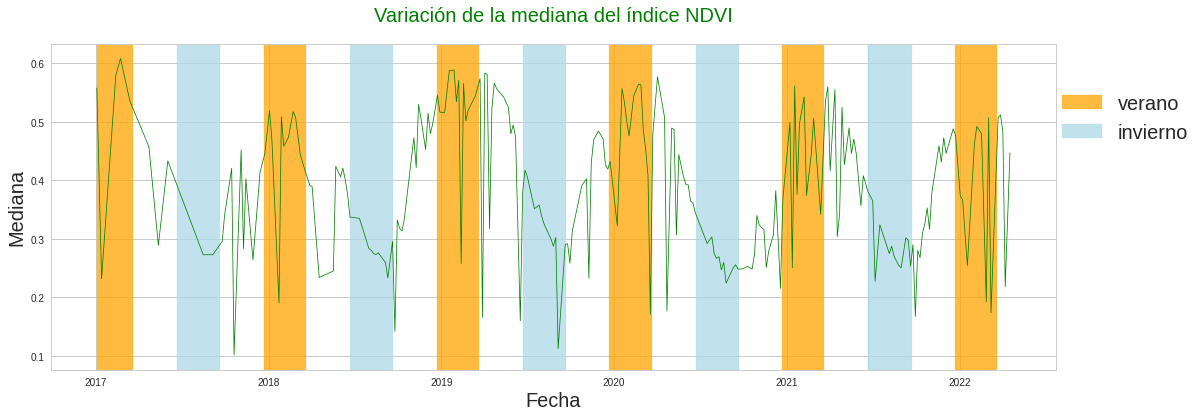

In [61]:
Sarmiento = df_[df_['name'] == 'Parque Sarmiento']
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(Sarmiento['date'], Sarmiento['ndvi_median'], color="green", linewidth=0.75)
yearlist = ['2017','2018','2019','2020','2021','2022']
for i in range(len(yearlist)):
  if yearlist[i] == '2017':
    ax.axvspan(mdates.date2num(datetime.datetime(2017,1,3)), mdates.date2num(datetime.datetime(2017,3,21)),
               color="orange",label="verano", alpha=0.75)
  if yearlist[i] == '2022':
    ax.axvspan(mdates.date2num(datetime.datetime(2021,12,22)), mdates.date2num(datetime.datetime(2022,3,21)),
               color="orange", alpha=0)
  else:
     ax.axvspan(mdates.date2num(datetime.datetime(int(yearlist[i]),12,22)), mdates.date2num(datetime.datetime(int(yearlist[i+1]),3,21))
           , color="orange", alpha=0.75)
     ax.axvspan(mdates.date2num(datetime.datetime(int(yearlist[i]),6,22)), mdates.date2num(datetime.datetime(int(yearlist[i]),9,21)),
            color="lightblue", alpha=0.75)
plt.axvspan(mdates.date2num(datetime.datetime(2021,6,22)), mdates.date2num(datetime.datetime(2021,6,23)),color="lightblue", label= "invierno", alpha=0.75)
plt.xlabel("Fecha", fontsize= 20)
plt.ylabel("Mediana", fontsize= 20)
plt.title("Variación de la mediana del índice NDVI", fontsize= 20, color="green", position=(0.5, 1.05))
plt.tight_layout
plt.style.use('seaborn-whitegrid')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.9), fontsize=20);

En el caso de la mediana del índice NDVI, la estacionalidad es más clara que en la mediana de la banda 02. Los picos de veranos son recurrentemente seguidos de un decenso progresivo en los valores de otoño, invierno y principios de primavera.

- Ahora extienda el analisis a todas las variables, son estacionales? Todas tienen el mismo tipo de estacionalidad? __Nota__: En este punto y etapa no se espera un criterio estricto de estacionalidad sino mostrar que bajo algun criterio (por ejemplo boxplots "similares" por temporada, etc) parecen serlo.

In [ ]:
# Creamos columnas específicas para año, mes y día
Sarmiento['date']= pd.to_datetime(Sarmiento['date'])
Sarmiento['year'] = Sarmiento['date'].dt.year
Sarmiento['month'] = Sarmiento['date'].dt.month
Sarmiento['day'] = Sarmiento['date'].dt.day
Month = Sarmiento['month']
Day= Sarmiento['day']

In [ ]:
# Creamos la columna específica "season" para las estaciones del año
# Para ello, podríamos utilizar dos criterios: simplificado o astronómico
# El criterio astronómico considera el inicio y fin de las estaciones el 21 de diciembre, marzo, junio y septiembre
# El criterio simplificado toma 3 meses completos para cada estación. Por ej. Verano está comprendido en enero, febrero y marzo.
# Este último contiene los datos de las 4 estaciones para un mismo año y es mejor para comparar datos anuales vs estacionales.
Seasons = []
for month, day in zip(Month, Day):
  if month in (1, 2, 3):
	  season = 'summer'
  elif month in (4, 5, 6):
	  season = 'autumn'
  elif month in (7, 8, 9):
	  season = 'winter'
  else:
	  season = 'spring'

# El código a continuación no se usa porque es el que se contempla para el criterio astronómico
  ''' if (month == 3) and (day > 20):
	  season = 'autumn'
  elif (month == 6) and (day > 20):
	  season = 'winter'
  elif (month == 9) and (day > 20):
	  season = 'spring'
  elif (month == 12) and (day > 20):
	  season = 'summer' '''
  Seasons.append(season)
Sarmiento['season']= Seasons

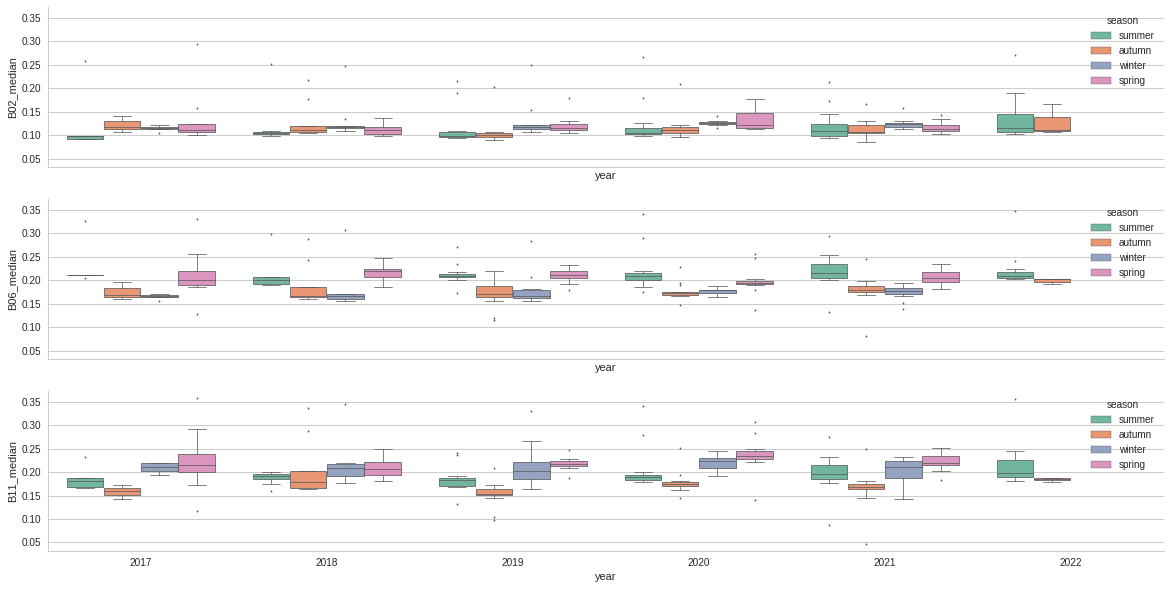

In [64]:
# Seleccionamos algunas bandas representativas (B02, B06 y B11) descartando las que tienen alta correlación
fig, axes = plt.subplots(3, 1, figsize=(20,10), sharex=True, sharey= True)
sns.boxplot(ax=axes[0], x="year", y="B02_median", hue="season",
                 data=Sarmiento, palette="Set2", fliersize=1, whis=1.5, linewidth=0.75)
sns.boxplot(ax=axes[1], x="year", y="B06_median", hue="season",
                 data=Sarmiento, palette="Set2", fliersize=1, whis=1.5, linewidth=0.75)
sns.boxplot(ax=axes[2], x="year", y="B11_median", hue="season",
                 data=Sarmiento, palette="Set2", fliersize=1, whis=1.5, linewidth=0.75)
sns.despine()

El gráfico previo incorpora nuevas bandas al análisis, relativizando la variación estacional observada anteriormente para la banda 2. Si bien, todas las bandas manifiestan cambios estacionales, las bandas 6 y 11 muestran cambios más importantes en términos absolutos. Por otra parte, la banda 6 es la que muestra una estacionalidad más semejante entre años, mientras que la banda 2 es la que tiene el comportamiento mas irregular entre años. Teniendo en cuenta que la vegetación responde a los cambios estacionales de tempertatura y radiación, es posible que las bandas 6 y 11 representen mejor las variaciones de estos fenómenos meteorológicos.  

- Seleccione un índice y grafique un boxplot para cada año. ¿Se mantiene inalterada en el tiempo la distribución? Que pasa si ese boxplot lo separa por estación (invierno,verano,otoño, primavera) y año son parecidas entre ellas en algun caso? Como se comportan año a año?

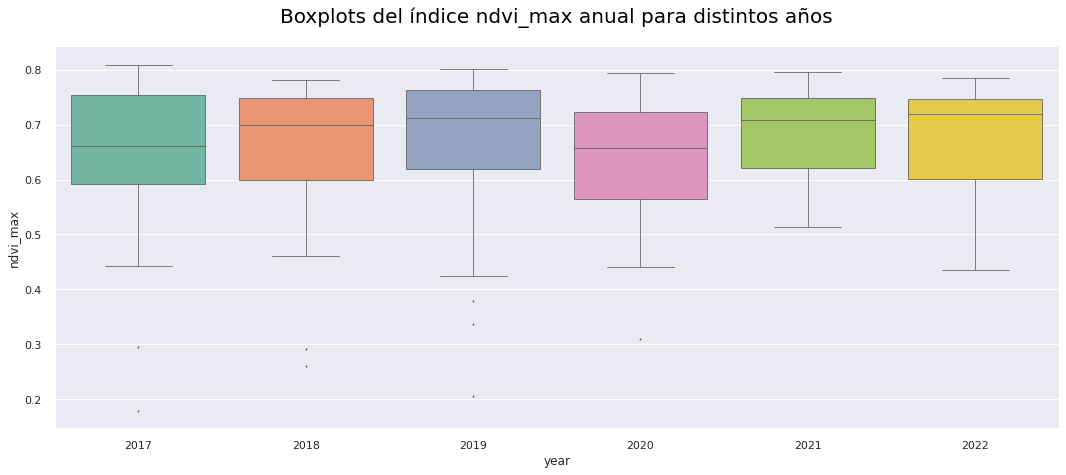

In [65]:
# Seleccionamos "ndvi_max" y realizamos la visualización de boxplots para cada año
plt.figure(figsize=(18,7))
sns.set(font_scale = 1)
g = sns.boxplot(x="year", y="ndvi_max", data=Sarmiento, palette="Set2", fliersize=1, whis=1.5, linewidth=0.75)                 
plt.title("Boxplots del índice ndvi_max anual para distintos años", fontsize= 20, color="black", position=(0.5, 1.05))
sns.despine() 

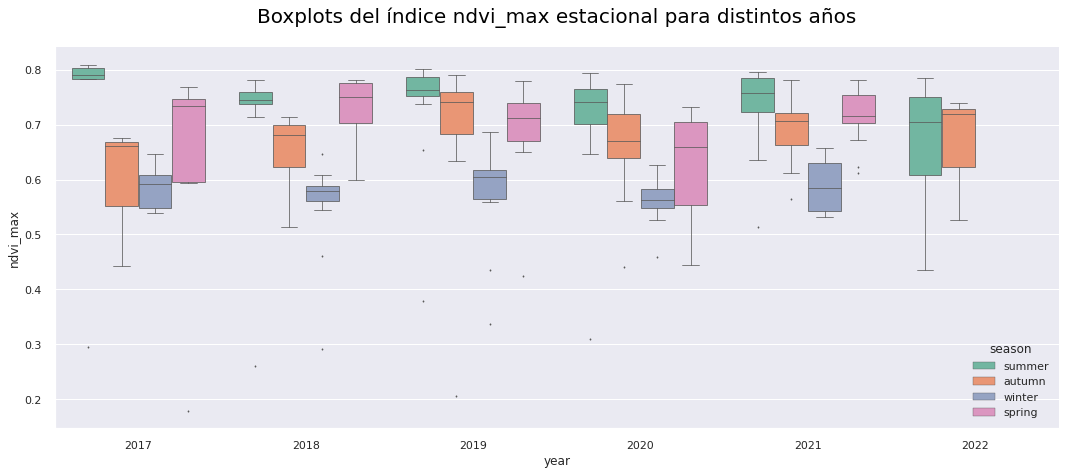

In [66]:
# Visualización de boxplots para cada año con sus estaciones
plt.figure(figsize=(18,7))
sns.set(font_scale = 1)
g = sns.boxplot(x="year", y="ndvi_max", hue="season", data=Sarmiento, palette="Set2", fliersize=1, whis=1.5, linewidth=0.75)                 
plt.title("Boxplots del índice ndvi_max estacional para distintos años", fontsize= 20, color="black", position=(0.5, 1.05))
sns.despine() 

Al analizar el boxplot del índice ndvi_max por año, es posible obervar que la distribución cambia muy poco entre años. Sin embargo cuando los datos se separan por estación se observa una marcada variabilidad.

- Tiene sentido calcular outliers para todo el tiempo de la serie o deberia segmentarse? Es decir, un outlier en otoño es lo mismo que en primavera o verano?

Para responder esta pregunta hacemos un análisis de los outliers sobre el límite superior de las distribuciones ya que parecen ser los mas evidentes. Tomamos como caso representativo la variable "ndvi_max" y los años 2017 y 2018. Cabe destacar que hasta ahora veníamos trabajando series temporales solo sobre los datos del **Parque Sarmiento**. A partir de aquí se trabaja con **toda la base de datos** ya que luego haremos evaluaciones que contemplan imagenes; y estas corresponden a toda la ciudad de Córdoba.

In [ ]:
df_interest['date'] = pd.to_datetime(df_interest['date'])
df_interest['year'] = df_interest['date'].dt.year # Creamos columna que solo contenga el año del registro
df_interest['month'] = df_interest['date'].dt.month # Creamos columna que solo contenga el mes del registro
df_interest['day'] = df_interest['date'].dt.day # Creamos columna que solo contenga el día del registro
Month = df_interest['month']
Day = df_interest['day']

In [ ]:
# Creamos columna de estaciones
Seasons = []
for month, day in zip(Month, Day):
  if month in (1, 2, 3):
	  season = 'summer'
  elif month in (4, 5, 6):
	  season = 'autumn'
  elif month in (7, 8, 9):
	  season = 'winter'
  else:
	  season = 'spring'
  Seasons.append(season)
df_interest['season']=Seasons

In [69]:
# Creamos un dataframe por año
df_2017=  df_interest[(df_interest['year'] == 2017)]
df_2017_summer=  df_interest[(df_interest['year'] == 2017) & (df_interest['season'] == "summer")]
df_2017_autumn=  df_interest[(df_interest['year'] == 2017) & (df_interest['season'] == "autumn")]
df_2017_winter=  df_interest[(df_interest['year'] == 2017) & (df_interest['season'] == "winter")]
df_2017_spring=  df_interest[(df_interest['year'] == 2017) & (df_interest['season'] == "spring")]

df_2018=  df_interest[(df_interest['year'] == 2018)]
df_2018_summer=  df_interest[(df_interest['year'] == 2018) & (df_interest['season'] == "summer")]
df_2018_autumn=  df_interest[(df_interest['year'] == 2018) & (df_interest['season'] == "autumn")]
df_2018_winter=  df_interest[(df_interest['year'] == 2018) & (df_interest['season'] == "winter")]
df_2018_spring=  df_interest[(df_interest['year'] == 2018) & (df_interest['season'] == "spring")]

In [70]:
#calculamos rango intercuartil para determinar analíticamente los outliers
#Años 2017 y 2018
q1 = df_2017['ndvi_max'].quantile(0.25)
q3 = df_2017['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2017 = q3 + 1.5 * iqr
q1 = df_2017_summer['ndvi_max'].quantile(0.25)
q3 = df_2017_summer['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2017_summer = q3 + 1.5 * iqr
q1 = df_2017_autumn['ndvi_max'].quantile(0.25)
q3 = df_2017_autumn['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2017_autumn = q3 + 1.5 * iqr
q1 = df_2017_winter['ndvi_max'].quantile(0.25)
q3 = df_2017_winter['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2017_winter = q3 + 1.5 * iqr
q1 = df_2017_spring['ndvi_max'].quantile(0.25)
q3 = df_2017_spring['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2017_spring = q3 + 1.5 * iqr

q1 = df_2018['ndvi_max'].quantile(0.25)
q3 = df_2018['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2018 = q3 + 1.5 * iqr
q1 = df_2018_summer['ndvi_max'].quantile(0.25)
q3 = df_2018_summer['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2018_summer = q3 + 1.5 * iqr
q1 = df_2018_autumn['ndvi_max'].quantile(0.25)
q3 = df_2018_autumn['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2018_autumn = q3 + 1.5 * iqr
q1 = df_2018_winter['ndvi_max'].quantile(0.25)
q3 = df_2018_winter['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2018_winter = q3 + 1.5 * iqr
q1 = df_2018_spring['ndvi_max'].quantile(0.25)
q3 = df_2018_spring['ndvi_max'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
ls_2018_spring = q3 + 1.5 * iqr

In [71]:
outl_2017=  df_2017[(df_2017['ndvi_max'] >ls_2017)] 
outl_2017_summer=  df_2017_summer[(df_2017_summer['ndvi_max'] >ls_2017_summer)] 
outl_2017_autumn=  df_2017_autumn[(df_2017_autumn['ndvi_max'] >ls_2017_autumn)] 
outl_2017_winter=  df_2017_winter[(df_2017_winter['ndvi_max'] >ls_2017_winter)]
outl_2017_spring=  df_2017_spring[(df_2017_spring['ndvi_max'] >ls_2017_spring)]

outl_2018=  df_2018[(df_2018['ndvi_max'] >ls_2018)]
outl_2018_summer=  df_2018_summer[(df_2018_summer['ndvi_max'] >ls_2018_summer)]
outl_2018_autumn=  df_2018_autumn[(df_2018_autumn['ndvi_max'] >ls_2018_autumn)]
outl_2018_winter=  df_2018_winter[(df_2018_winter['ndvi_max'] >ls_2018_winter)]
outl_2018_spring=  df_2018_spring[(df_2018_spring['ndvi_max'] >ls_2018_spring)]

print("Cantidad de outliers sobre el límite superior de la distribución, para la variable ndvi_max, de acuerdo al segmento de datos analizados:")
print("El año 2017 en su conjunto, presenta", len(outl_2017), "outlier/s")
print("El verano del año 2017, presenta",len(outl_2017_summer), "outlier/s")
print("El otoño del año 2017, presenta",len(outl_2017_autumn), "outlier/s")
print("El invierno del año 2017, presenta",len(outl_2017_winter), "outlier/s")
print("La primavera del año 2017, presenta",len(outl_2017_spring), "outlier/s")

print("El año 2018 en su conjunto, presenta", len(outl_2018), "outlier/s")
print("El verano del año 2018, presenta",len(outl_2018_summer), "outlier/s")
print("El otoño del año 2018, presenta",len(outl_2018_autumn), "outlier/s")
print("El invierno del año 2018, presenta",len(outl_2018_winter), "outlier/s")
print("La primavera del año 2018, presenta",len(outl_2018_spring), "outlier/s")

Cantidad de outliers sobre el límite superior de la distribución, para la variable ndvi_max, de acuerdo al segmento de datos analizados:
El año 2017 en su conjunto, presenta 0 outlier/s
El verano del año 2017, presenta 0 outlier/s
El otoño del año 2017, presenta 0 outlier/s
El invierno del año 2017, presenta 26 outlier/s
La primavera del año 2017, presenta 0 outlier/s
El año 2018 en su conjunto, presenta 1 outlier/s
El verano del año 2018, presenta 1 outlier/s
El otoño del año 2018, presenta 0 outlier/s
El invierno del año 2018, presenta 35 outlier/s
La primavera del año 2018, presenta 1 outlier/s


Mediante el cálculo analítico de los outliers para el índice ndvi_max en los años 2017 y 2018 es posible afirmar que los outlier no son lo mismo si se calculan en un intervalo anual o por estaciones. Por ejemplo, en el año 2018 se registra un único outlier si es analizado en su conjunto, frente a la estación de invierno que presenta 22 outliers. Es por ello que el cálculo de dichos valores atípicos debería realizarse sobre segmentos de tiempo de la serie.

- Sobre datos faltantes, existe algun intervalo temporal en el cual esto parezca ser mas recurrente (observe [ab-initio-data-build](../data/ab-initio-dataset-build.md) # Imagenes CBA) ? 

    __Punto Extra__: replique la imágen _cantidad de imágenes por fecha y nubosidad_, se le ocurre alguna forma alternativa de representarlo?

In [72]:
# Analizamos si los datos faltantes se encuentran dentro de un intervalo temporal recurrente
# Para ello, graficamos por separado cada año a fin de comparar las épocas donde existen datos faltantes
# Agrupamos por "date" para contar con un solo valor por fecha, eligiendo un indicador cualquiera ("max" en este caso)
df_interest['day_of_year'] = df_interest['date'].dt.strftime('%j') # Creamos columna 'day_of_year'
df_interest['day_of_year'] = df_interest['day_of_year'].astype('int')
data2017 = df_interest[df_interest['year'] == 2017].groupby(df_interest['date']).agg(max)
data2018 = df_interest[df_interest['year'] == 2018].groupby(df_interest['date']).agg(max)
data2019 = df_interest[df_interest['year'] == 2019].groupby(df_interest['date']).agg(max)
data2020 = df_interest[df_interest['year'] == 2020].groupby(df_interest['date']).agg(max)
data2021 = df_interest[df_interest['year'] == 2021].groupby(df_interest['date']).agg(max)
# Utilizamos solo una variable (ndvi_max) ya que todas las demás están correlacionadas con esta en cuanto a datos faltantes
# Obtenemos una nueva columna "gaps" que mostrará un valor de 1 si hay datos en cada date. 
data2017['gaps'] = data2017.ndvi_max/data2017.ndvi_max
data2018['gaps'] = data2018.ndvi_max/data2018.ndvi_max
data2019['gaps'] = data2019.ndvi_max/data2019.ndvi_max
data2020['gaps'] = data2020.ndvi_max/data2020.ndvi_max
data2021['gaps'] = data2021.ndvi_max/data2021.ndvi_max
# Comparamos los períodos donde faltan datos en cada año, utilizando como eje x común la variable 'day_of_year' 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, subplot_titles=('2017','2018','2019','2020','2021'), x_title='Day of year')
fig.add_trace(go.Scatter(x=data2017['day_of_year'],y=data2017['gaps']), row=1, col=1)
fig.add_trace(go.Scatter(x=data2018['day_of_year'],y=data2018['gaps']), row=2, col=1)
fig.add_trace(go.Scatter(x=data2019['day_of_year'],y=data2019['gaps']), row=3, col=1)
fig.add_trace(go.Scatter(x=data2020['day_of_year'],y=data2020['gaps']), row=4, col=1)
fig.add_trace(go.Scatter(x=data2021['day_of_year'],y=data2021['gaps']), row=5, col=1)
fig.update_layout(showlegend=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



La gráfica anterior muestra que el faltante de datos no tiene un comportamiento recurrente en el tiempo, por lo que parece independiente de la época del año.

- Sobre los outliers, elija alguna banda o indice y compute los outliers (bajo algun criterio que le parezca razonable), ahora contraste los mismos (o el rango de los mismos) con la representacion de los rasters ( descargables desde: [parches rbg/cloud-mask](https://drive.google.com/file/d/1VJnFvc9waDWPzm0i6UitKwlOSaQVwn_j/view?usp=sharing) ), su eleccion de outliers parece sostenerse? O esta desechando datos que podrian servir?

Para este item nos enfocaremos en el año 2018 y utilizaremos los resultados obtenidos de los outilers calculados para la variable ndvi_max en items anteriores. Consideramos el cálculo matemático necesario para la gráfica de los boxplots para los outliers por encima del límte superior y por debajo del límite inferior.

In [73]:
#Agregamos cálculo del límite inferior del boxplot (Anual y estacional)
li_2018 = q1 - 1.5 * iqr
li_2018_summer = q1 - 1.5 * iqr
li_2018_autumn = q1 - 1.5 * iqr
li_2018_winter = q1 - 1.5 * iqr
li_2018_spring = q1 - 1.5 * iqr

In [74]:
#Agregamos cálculo de outliers por debajo del límite inferior del boxplot (Anual y estacional)
outli_2018=  df_2018[(df_2018['ndvi_max'] <ls_2018)]
outli_2018_summer=  df_2018_summer[(df_2018_summer['ndvi_max'] <li_2018_summer)]
outli_2018_autumn=  df_2018_autumn[(df_2018_autumn['ndvi_max'] <li_2018_autumn)]
outli_2018_winter=  df_2018_winter[(df_2018_winter['ndvi_max'] <li_2018_winter)]
outli_2018_spring=  df_2018_spring[(df_2018_spring['ndvi_max'] <li_2018_spring)]

Mostramos específicamente los outliers estacionales para el año 2018 y a modo de comparación las imágenes que se corresponden a los días que presentan outliers para los límites superior e inferior.

In [75]:
print("Outliers límite superior")
print(" Anual-2018        ")
print(outl_2018)
print("*******************************************************")
print("*******************************************************")
print("    Verano-2018       ")
print(outl_2018_summer)
print("     Otoño 2018      ")
print(outl_2018_autumn)
print("    Invierno 2018       ")
print(outl_2018_winter)
print("     Primavera 2018      ")
print(outl_2018_spring)

Outliers límite superior
 Anual-2018        
       B02_median  B06_median  B11_median     osm_id       date  ndvi_max  \
57499      0.1234       0.273      0.2991  309277132 2018-11-29  0.999486   

           area_m2  year  month  day  season  
57499  1602.647511  2018     11   29  spring  
*******************************************************
*******************************************************
    Verano-2018       
       B02_median  B06_median  B11_median   osm_id       date  ndvi_max  \
21704      0.0833      0.1144       0.065  5969352 2018-01-23  0.828961   

            area_m2  year  month  day  season  
21704  1.207784e+06  2018      1   23  summer  
     Otoño 2018      
Empty DataFrame
Columns: [B02_median, B06_median, B11_median, osm_id, date, ndvi_max, area_m2, year, month, day, season]
Index: []
    Invierno 2018       
       B02_median  B06_median  B11_median     osm_id       date  ndvi_max  \
40510     0.12210     0.20000     0.28350  698755844 2018-07-12  0.65

**NOTA:** Al comparar las fechas de outliers por encima del límite superior, tanto para el año completo como para cada estación, con las imágenes provistas en [parches rbg/cloud-mask](https://drive.google.com/file/d/1VJnFvc9waDWPzm0i6UitKwlOSaQVwn_j/view?usp=sharing), no encontramos imágenes para tales fechas. 

In [76]:
print("Outliers límite inferior")
print(" Anual-2018        ")
print(outli_2018)
print("*******************************************************")
print("*******************************************************")
print("    Verano-2018       ")
print(outli_2018_summer)
print("     Otoño 2018      ")
print(outli_2018_autumn)
print("    Invierno 2018       ")
print(outli_2018_winter)
print("     Primavera 2018      ")
print(outli_2018_spring)

Outliers límite inferior
 Anual-2018        
       B02_median  B06_median  B11_median     osm_id       date  ndvi_max  \
19682     0.09965     0.22835      0.2021  361105105 2018-01-03  0.650704   
19683     0.13285     0.26375      0.2982  559322367 2018-01-03  0.515817   
19684     0.11140     0.25240      0.2453  559322368 2018-01-03  0.644150   
19685     0.11540     0.26150      0.2608  559322369 2018-01-03  0.598301   
19686     0.11875     0.29035      0.2734  559328111 2018-01-03  0.659861   
...           ...         ...         ...        ...        ...       ...   
61312     0.10080     0.21900      0.2023  361102869 2018-12-29  0.663320   
61313     0.13840     0.27360      0.3148  924965690 2018-12-29  0.487695   
61314     0.13210     0.20020      0.1855   25622122 2018-12-29  0.659574   
61315     0.12850     0.27230      0.3181  924965689 2018-12-29  0.553886   
61316     0.11390     0.21250      0.2225   23300957 2018-12-29  0.652428   

            area_m2  year  mon

Al analizar los outliers por encima del límite superior observamos que estos no tenían imágenes para poder comparar. Para los outliers por debajo del límite inferior observamos que se corresponden tanto para imágenes con nubes como sin nubes. También pudimos observar que las fechas para outliers por encima del límte superior tenían fechas coincidentes para ouliers por debajo del límite inferior. Es decir, que la fecha dada que se corresponde con un outlier por encima del límite superior siempre encuentra un outlier por debajo del límite inferior para dicha fecha. Luego de este análisis podemos afirmar que si desechamos datos que se corresponden con imágenes para outliers por encima del límte superior, estaríamos cometiendo un error ya que dichas imágenes no se encuentran y no podemos afirmar algo respecto a ellas. Si desechamos imágenes por debajo del límite inferior estaríamos descartando imágenes que no presentan nubes, por ejemplo. Es probable que el índice ndvi_max no sea un buen candidato para calcular outliers para poder comparar con imágenes RGB (las imágenes RGB son composiciones de tres bandas de color).


Imagen que se corresponde con un outlier por encima del límite superior y por debajo del límite inferior

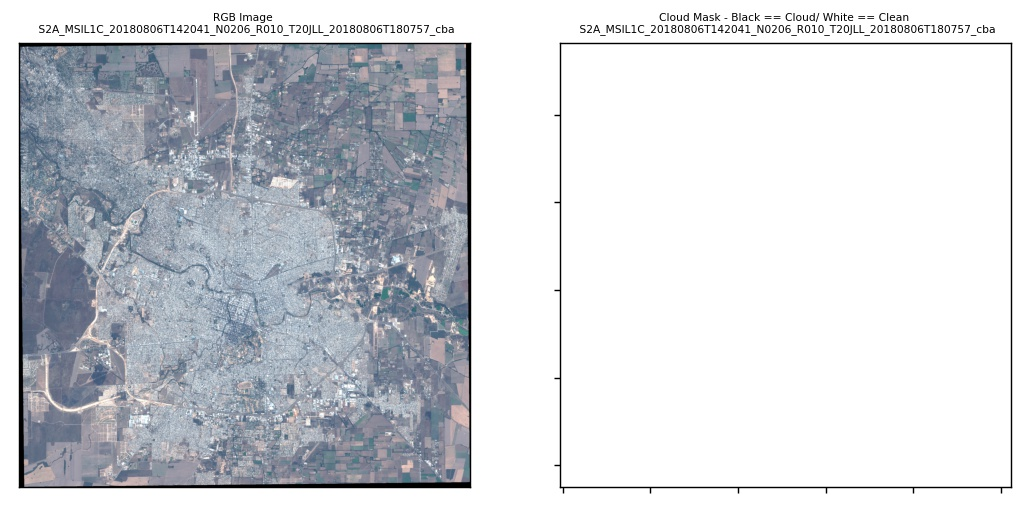

Imagen que se corresponde únicamente con un outlier por debajo del límite inferior

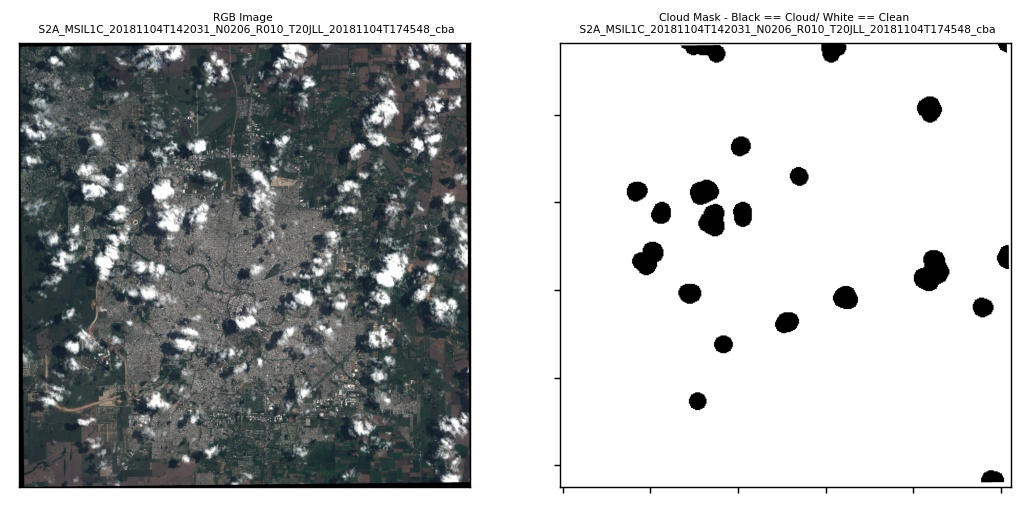

- __Punto Extra__: Explique el indice NDVI, y su aplicabilidad para observar la evolución de cultivos. ¿Esto nos serviria para monitorear plazas y parques?

##Índice de Vegetación de Diferencia Normalizada (NDVI)
El Índice de Vegetación de Diferencia Normalizada es un indicador simple de biomasa fotosintéticamente activa o, en términos simples, un cálculo de la salud de la vegetación. Este índice puede utilizarse para diferenciar la vegetación de otros tipos de cobertura del suelo (artificial) y determinar su estado general. También permite definir y visualizar áreas con vegetación en el mapa, así como detectar cambios anormales en el proceso de crecimiento.

El índice NDVI se obtiene comparando matemáticamente la cantidad de luz roja visible absorbida y la luz infrarroja cercana reflejada. Esto es posible debido a que el pigmento de clorofila en una planta sana absorbe la mayor parte de la luz roja visible, mientras que la estructura celular de una planta refleja la mayor parte de la luz infrarroja cercana. Esto significa que una alta actividad fotosintética, comúnmente asociada con vegetación densa, tendrá menos reflectancia en la banda roja y mayor reflectancia en el infrarrojo cercano. Al observar cómo estos valores se comparan entre sí, se puede detectar y analizar de manera confiable la cubierta vegetal por separado de otros tipos de coberturas naturales del suelo.

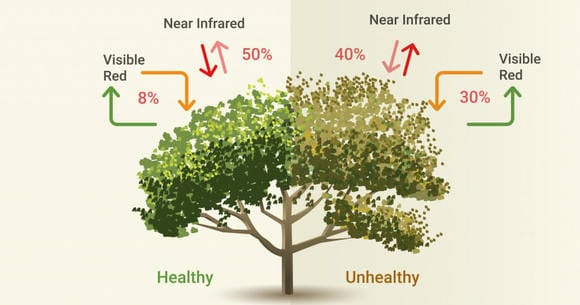

Los valores del NDVI varían de -1 a 1. Los valores negativos corresponden a áreas con superficies de agua, estructuras artificiales, rocas, nubes, nieve; el suelo desnudo generalmente cae dentro del rango de 0.1 a 0.2; y las plantas siempre tendrán valores positivos entre 0.2 y 1. El dosel de vegetación sano y denso debería estar por encima de 0.5, y la vegetación dispersa probablemente caerá dentro de 0.2 a 0.5. Sin embargo, es solo una regla general y siempre debe tenerse en cuenta la temporada, el tipo de planta y las peculiaridades regionales para saber exactamente cómo se comportan los valores de NDVI.

##Aplicabilidad en la evolución de los cultivos
El NDVI mide el estado y la salud de los cultivos o el vigor de los cultivos, es decir que es un indicador de verdor y además tiene una fuerte correlación con la biomasa verde, que es indicativa de crecimiento. También se sabe que este índice tiene una fuerte correlación con las etapas fenológicas del cultivo (emergido, madurez, cosecha). Sin embargo, existen ciertas limitaciones. Por ejemplo, durante las primeras etapas del crecimiento del cultivo, cuando el área de hojas verdes es pequeña, los resultados del NDVI son muy sensibles a los efectos de fondo del suelo. El NDVI también puede saturarse en etapas posteriores, cuando los cultivos alcanzan el cierre del dosel y producir resultados inexactos.

Fuente: [EARTH OBSERVING SYSTEM](https://eos.com/) 

##Monitoreo de plazas y parques
Dado que es posible medir la biomasa y evaluar el estado y la salud de los cultivos, pensamos que sería posible monitorear plazas y parques utilizando el índice NDVI. Deberíamos poder realizar análisis de cómo va variando este índice a lo largo del año.

- __Punto Extra__: Se le ocurre alguna forma de normalizar los datos para hacernos independientes de los años (pero si mantener la estacionalidad)? 
- __Punto Extra__: El tipo de sensor que estamos considerando esta afectado fuertemente por las condiciones luminicas, puede encontrar algún par de {imagenes, indices} que parezcan representar esta situación? Para ello deberia seleccionar imagenes cercanas temporalmente (misma semana o mes, sin nubes) y obtener sus indices. Podria concluir algo a partir de eso? O le hacen falta mas datos? (Respuesta preliminar: la informacion brindada parece ser insuficiente) 
- ¿Dado un indice, es capaz de encontrar algun rango temporal en el cual parezca romperse la estacionalidad? (Esto lo podria intentar contrastar con las imagenes en rgb para ello le recomendamos que elija un espacio verde extenso)
- Le parece que existen espacios verdes que no sean susceptibles de ser monitoreados via las bandas o indices? 

Dado que la resolución espacial aplicada es de 10 metros, es posible que espacios verdes muy pequeños (<50 metros cuadrados), no sean pasibles de ser analizados con suficiente precisión. Esto es porque dentro de cada pixel de 10 x 10 metros puede haber otros elementos como fuentes, bancos, hamacas, pasarelas, etc. que desvirtúen el valor de reflectancia y generen "ruido" en el análisis. Esto también está presente en grandes superficies, pero en estos casos es más común la presencia de espacios verdes libres de "ruidos", con lo cual se diluye su interferencia al realizar el análisis global del sitio. 

__Punto Extra__: Podria generar condiciones o criterios (tamaño, reflectancia en alguna banda, etc) que nos indiquen si un dado espacio es monitoreable ( o no) via imágenes satelitales?

##Conclusiones
Se considerará como positivo la capacidad de generar conclusiones o analisis que permitan construir nuevo conocimiento en base a los datos provistos.
Respecto a las conclusiones, se espera que a partir de los puntos [3] y [4] hayan podido conocer el dataset y tener una idea (linea de acción) para mitigar o atacar temas tales como:
- Outliers?
- Faltantes de datos?
- Todas las variables son relevantes?
- etc

No hay límites respecto a la extensión, pero se valorará el poder de síntesis y de comunicación, así como el uso de las herramientas pertinentes..

El dataset cuenta con una enorme cantidad de variables que en su mayoría no tendrían utilidad para un análisis de la salud de la vegetación, ya que por ejemplo las bandas por si solas no contribuyen con información relevante para el monitoreo. No obstante, las bandas son insumos para el cálculo del índice NDVI que sí aporta información clave para el presente estudio. Luego, hay otras variables indispensables como los identificadores de registro y el nombre de cada espacio verde. Por su parte, la columna de fechas permite los análisis de la serie temporal. Por último, el área de cada espacio verde también es un indicador relevante para analizar las posibilidades de monitorear un determinado sitio.

El análisis del dataset también permitió detectar outliers, los cuales en su mayoría parecen ser simplemente valores altos de indicadores y bandas propios de la estación del año que se analice. Sin embargo, se detectaron algunos valores negativos que no son posibles físicamente y que deberían ser tratados previo a continuar el uso de la base de datos. 

En cuanto a los valores faltantes, parece haber una causa común para su ausencia ya que están altamente correlacionados. No obstante, esto no parece ser un problema de recurrencia estacional. Es importante investigar las causas antes de proceder a la eliminación de los registros completos o a la imputación de nuevos valores.